In [1]:
import pandas as pd
import numpy as np
import random

def generate_customer_segmentation_df(n_customers=200, random_seed=42):
    np.random.seed(random_seed)
    random.seed(random_seed)

    # Generate CustomerID
    customer_ids = range(1, n_customers + 1)

    # Age between 18 and 70
    ages = np.random.randint(18, 71, size=n_customers)

    # Gender: Male or Female
    genders = np.random.choice(['Male', 'Female'], size=n_customers)

    # Annual Income between $15k and $150k
    annual_income = np.random.normal(loc=60, scale=20, size=n_customers).clip(15, 150).round(1)

    # Spending Score (1-100)
    spending_score = np.random.randint(1, 101, size=n_customers)

    # Membership level (categorical)
    membership_levels = np.random.choice(['Silver', 'Gold', 'Platinum'], size=n_customers, p=[0.5, 0.3, 0.2])

    # Create the DataFrame
    df = pd.DataFrame({
        'CustomerID': customer_ids,
        'Age': ages,
        'Gender': genders,
        'Annual Income (k$)': annual_income,
        'Spending Score (1-100)': spending_score,
        'Membership Level': membership_levels
    })

    return df

In [2]:
df = generate_customer_segmentation_df(n_customers=500)
df.head()

,CustomerID,Age,Gender,Annual Income (k$),Spending Score (1-100),Membership Level
0,1,56,Male,36.3,58,Silver
1,2,69,Male,19.2,87,Silver
2,3,46,Female,54.6,26,Gold
3,4,32,Female,74.4,98,Gold
4,5,60,Male,90.0,46,Gold


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              500 non-null    int64  
 1   Age                     500 non-null    int32  
 2   Gender                  500 non-null    object 
 3   Annual Income (k$)      500 non-null    float64
 4   Spending Score (1-100)  500 non-null    int32  
 5   Membership Level        500 non-null    object 
dtypes: float64(1), int32(2), int64(1), object(2)
memory usage: 19.7+ KB


In [4]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [5]:
categorical_columns = ['Gender', 'Membership Level']
numerical_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
df.drop('CustomerID', axis=1, inplace=True)

In [6]:
preprocessor = ColumnTransformer([
    ('std', StandardScaler(), numerical_columns),
    ('ohc', OneHotEncoder(), categorical_columns)
])

In [7]:
wcss = []

K_cluster = range(1, 11)

for k in K_cluster:  
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('kmeans', KMeans(n_clusters=k, random_state=0))
    ])

    # Fit pipeline
    pipeline.fit(df)

    # Extract inertia_ from KMeans step
    inertia = pipeline.named_steps['kmeans'].inertia_
    wcss.append(inertia)

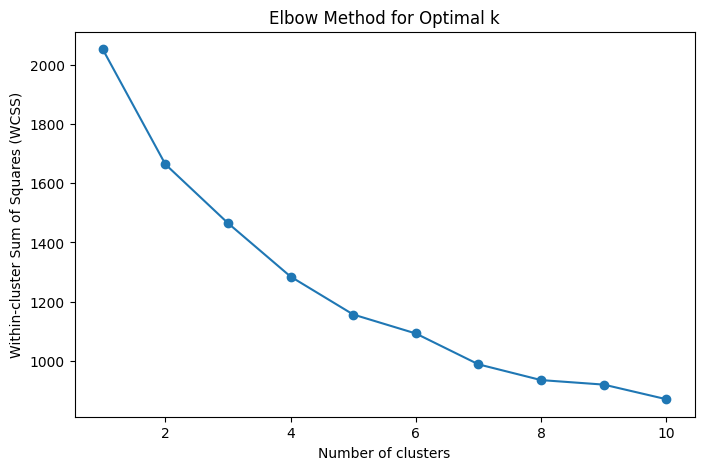

In [8]:
import matplotlib.pyplot as plt
# Plot Elbow Method
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()

In [9]:
from kneed import KneeLocator

kneedle = KneeLocator(K_cluster, wcss, curve='convex', direction='decreasing')
optimal_k = kneedle.knee
print("Optimal k found at:", optimal_k)

Optimal k found at: 4


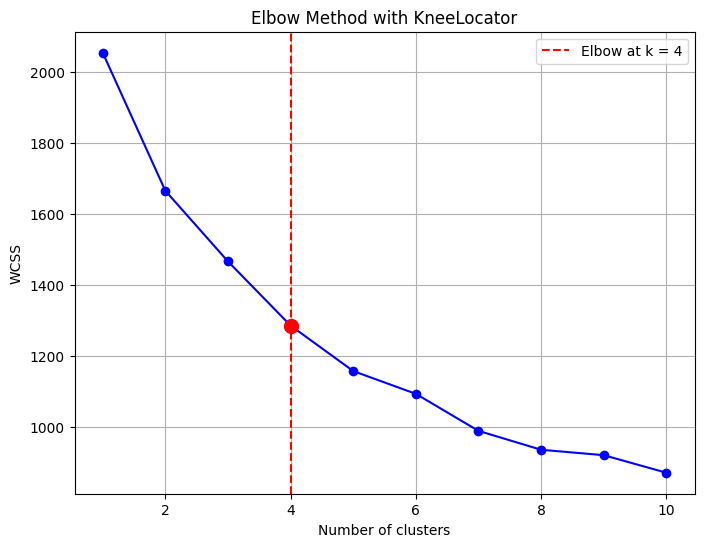

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(K_cluster, wcss, 'bo-')
plt.axvline(optimal_k, color='red', linestyle='--', label=f'Elbow at k = {optimal_k}')
plt.plot(optimal_k, wcss[optimal_k - 1], 'ro', markersize=10)
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method with KneeLocator")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
final_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('kmeans', KMeans(n_clusters=optimal_k, random_state=42))
])

final_pipeline.fit(df)
df['Cluster'] = final_pipeline.named_steps['kmeans'].labels_
df.head(10)

,Age,Gender,Annual Income (k$),Spending Score (1-100),Membership Level,Cluster
0,56,Male,36.3,58,Silver,1
1,69,Male,19.2,87,Silver,1
2,46,Female,54.6,26,Gold,1
3,32,Female,74.4,98,Gold,2
4,60,Male,90.0,46,Gold,3
5,25,Male,61.5,98,Platinum,2
6,38,Female,92.6,29,Gold,0
7,56,Female,32.4,4,Gold,1
8,36,Female,25.9,81,Silver,2
9,40,Female,58.9,99,Gold,2


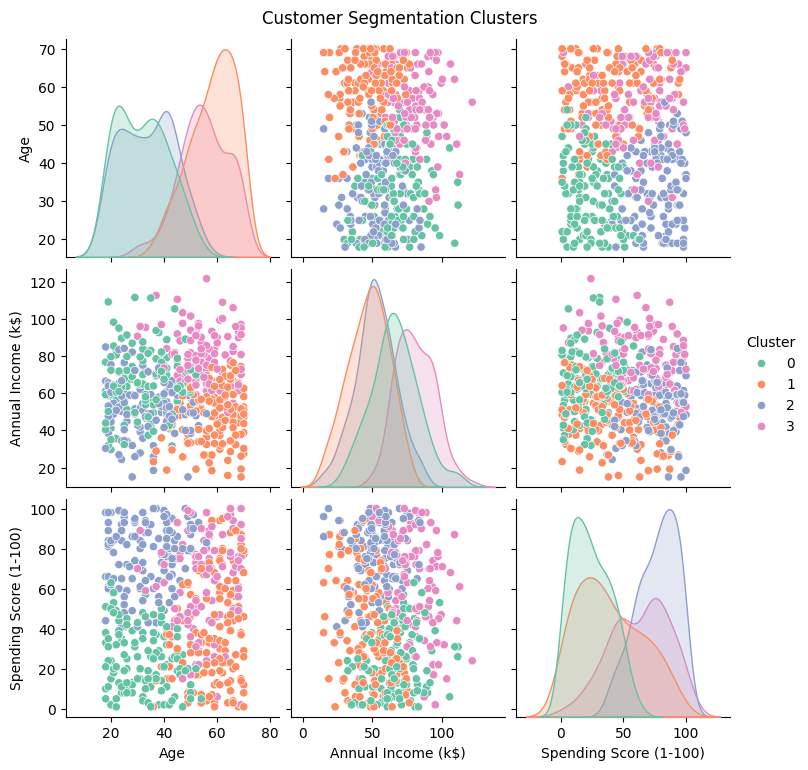

In [12]:
import seaborn as sns
sns.pairplot(df, hue='Cluster', vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], palette='Set2')
plt.suptitle('Customer Segmentation Clusters', y=1.02)
plt.show()

In [13]:
# Example new customer data
new_data = pd.DataFrame({
    'Gender': ['Female'],
    'Membership Level': ['Gold'],
    'Age': [32],
    'Annual Income (k$)': [75],
    'Spending Score (1-100)': [60]
})

# Predict cluster for new data using the full pipeline
predicted_cluster = final_pipeline.predict(new_data)

print(f"New data assigned to cluster: {predicted_cluster[0]}")

New data assigned to cluster: 2


In [14]:
# Get numeric summaries
cluster_summary = df.groupby('Cluster').agg({
    'Age': ['mean', 'min', 'max'],
    'Annual Income (k$)': ['mean', 'min', 'max'],
    'Spending Score (1-100)': ['mean', 'min', 'max'],
    'Gender': lambda x: x.mode()[0],  # Most common gender
    'Membership Level': lambda x: x.mode()[0]  # Most common membership
}).reset_index()

# Clean column names
cluster_summary.columns = ['_'.join(col).strip('_') for col in cluster_summary.columns.values]
cluster_summary

,Cluster,Age_mean,Age_min,Age_max,Annual Income (k$)_mean,Annual Income (k$)_min,Annual Income (k$)_max,Spending Score (1-100)_mean,Spending Score (1-100)_min,Spending Score (1-100)_max,Gender_<lambda>,Membership Level_<lambda>
0,0,31.904000,18,54,66.196000,29.7,111.5,24.144000,1,63,Male,Silver
1,1,58.323741,36,70,47.095683,15.0,76.4,38.992806,1,95,Female,Silver
2,2,33.804688,18,56,52.128125,15.0,84.9,76.812500,37,100,Female,Silver
3,3,55.037037,30,69,80.696296,49.7,121.6,62.657407,2,100,Male,Silver


| Cluster | Age (mean) | Income (mean, k\$) | Spending Score (mean) | Most Common Gender | Most Common Membership | Interpretation & Strategy                                                                                                                                                            |
| ------- | ---------- | ------------------ | --------------------- | ------------------ | ---------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **0**   | 31.9       | 66.2               | 24.1                  | Male               | Silver                 | **Young males with high income but very low spending.**<br>Could indicate cautious spenders or occasional buyers. Marketing: Explore incentives to increase engagement and spending. |
| **1**   | 58.3       | 47.1               | 39.0                  | Female             | Silver                 | **Older females with moderate income and moderate-low spending.**<br>Likely budget-conscious. Strategy: Loyalty programs, discounts, value offers.                                   |
| **2**   | 33.8       | 52.1               | 76.8                  | Female             | Silver                 | **Young females with moderate income and very high spending.**<br>Active customers, prime targets for premium/up-sell offers and personalized marketing.                             |
| **3**   | 55.0       | 80.7               | 62.7                  | Male               | Silver                 | **Older males with high income and above average spending.**<br>Potential loyal customers with good engagement. Strategy: Reward programs, exclusive offers.                         |

# Summary

- **Cluster 0:** High-income young males but low spenders — opportunity to boost spending.

- **Cluster 1:** Older, moderate income females with lower spending — focus on value and retention.

- **Cluster 2:** Young, moderate income females with high spending — your best customers for premium products.

- **Cluster 3:** Older males with high income and moderate-high spending — valuable loyal group.

# Example for Actionable Next Steps Roadmap to Turn Your Clustering Insights into Real Business Value 

1. **Validate & Refine Clusters**
   - Check cluster stability: Run clustering multiple times or on bootstrap samples to confirm robustness.
   - Try alternative algorithms: e.g., Gaussian Mixture Models, DBSCAN to see if clusters improve.
   - Add more features: Customer tenure, transaction frequency, product preferences, etc., for deeper segmentation.

2. **Deep Dive into Cluster Profiles**
   - Create detailed profiles per cluster including:
     - Demographics
     - Purchase behaviors
     - Customer lifetime value (if available)
   - Use visualization (boxplots, histograms) to understand distribution within clusters.

3. **Build Targeted Strategies**
   - For each cluster, design marketing campaigns tailored to their behavior:
     - **Cluster 0:** Incentives to increase spending (discounts, loyalty points)
     - **Cluster 1:** Value-driven offers and retention programs
     - **Cluster 2:** Premium product promotions and upselling
     - **Cluster 3:** Exclusive rewards and VIP experiences

4. **Deploy the Model**
   - Save your pipeline with preprocessing + clustering.
   - Integrate into your CRM or marketing automation platform.
   - Use for real-time customer segmentation on new customers.

5. **Monitor & Update**
   - Track cluster membership over time; customers may shift segments.
   - Periodically retrain model with fresh data.
   - Measure impact of targeted campaigns on cluster behavior and ROI.

6. **Explore Predictive Modeling**
   - Use clusters as features or labels in supervised learning to:
     - Predict customer churn.
     - Forecast spending.
     - Personalize recommendations.

In [15]:
df['Cluster'].value_counts().sort_index()

Cluster
0    125
1    139
2    128
3    108
Name: count, dtype: int64

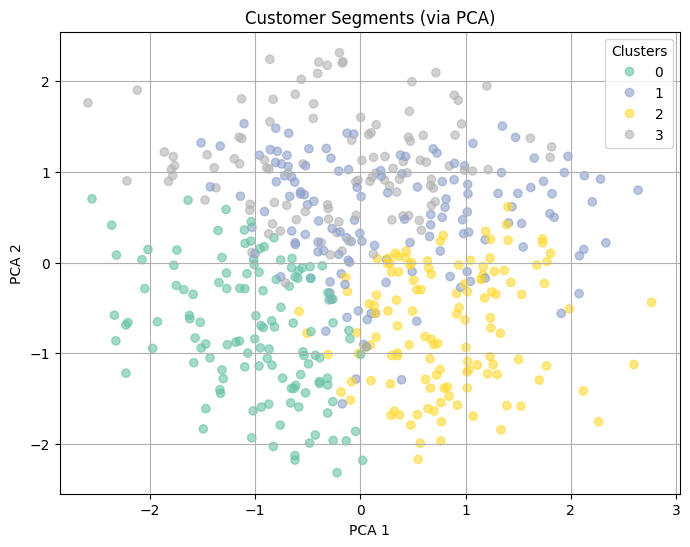

In [16]:
from sklearn.decomposition import PCA

# Apply preprocessing to all features
X_processed = final_pipeline.named_steps['preprocess'].transform(df.drop(columns='Cluster'))

# Reduce to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_processed)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['Cluster'], cmap='Set2', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("Customer Segments (via PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

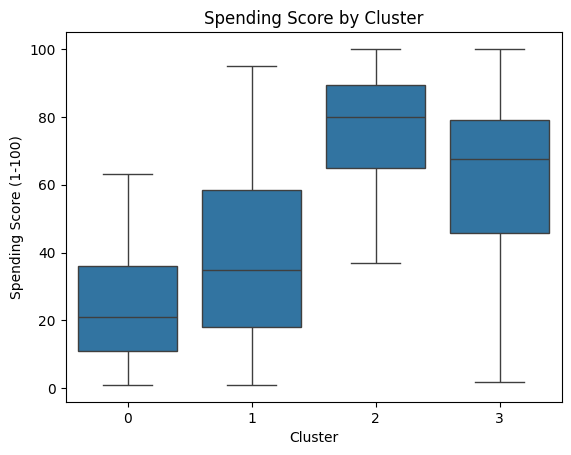

In [17]:
import seaborn as sns

sns.boxplot(data=df, x='Cluster', y='Spending Score (1-100)')
plt.title('Spending Score by Cluster')
plt.show()